In [27]:
import torch  
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

"Using Cuda" if torch.cuda.is_available() else "Not using Cuda"

'Using Cuda'

# Machine Learning - Networks

suppose we have data consists of an independent vector an a dependent vector $x_i$ and $y_i$ where $i$ is the $i^{\text{th}}$ value in the data set.

- $x_i$ is the height of the $i^{\text{th}}$ person and $y_i$ is their weight 
- $x_i$ is a picture of handwritten digits and $y_i$ is the digit itself 
- $x_i$ is a CT-Scan of a patient and $y_i$ are the pixels corresponding to tumours. 

Goal of a neural network is to define $f$ that make predictions based on parameters $a$.

$$\hat{y}_i = f(x_i; a)$$

We want to minimize the difference $y_i$ $\hat{y}_i$ and we do this by defining a loss function $L : Y\times Y \mapsto \mathbb{R}$ (where $Y$ is the output space i.e. $y_i, \hat{y}_i \in Y$) to tell us how dis-similar two things. 

A common loss function is RSS $$L_\text{RSS}(y,\hat{y}) = \sum\limits^{n}_{i=1} (y_i - \hat{y}_i)^2$$


In [28]:
f_original = lambda a,b: a*2 + b + 2
num_points = 32
x = torch.tensor([[i, j] for i in range(num_points) for j in range(num_points)], dtype=torch.float32)
y = torch.tensor([f_original(a,b) for a,b in x], dtype=torch.float32)

Recall our goal is to fit a function $f$ using parameters $a$ to best predict $\hat{y}$ according loss function $L$. Here are our ideas 

1. First multiply each term in $x$ by matrix $M_1 \in \mathbb{R}^{8 \times 2}$ 
    1. So we take our out two inputs and scale them to the first layer with 8 nodes
1. Then multiply each term from the output of $M_1$ by matrix $M_2 \in \mathbb{R}^{1 \times 8}$ 
    1. Take from the last layer with 8 nodes to the output (1 node)

So we have 24 parameters for $a$. 

In [29]:
layer_size = 32
M1 = nn.Linear(2,layer_size, bias = False) # creates an 8 x 2 matrix 
M1 

Linear(in_features=2, out_features=32, bias=False)

In [30]:
M2 = nn.Linear(layer_size,1, bias = False) # creates an 1 x 8 matrix 
M2

Linear(in_features=32, out_features=1, bias=False)

In [31]:
M2(M1(x)).squeeze()  # calling squeeze removes the extra dimension of size 1

tensor([0.0000e+00, 1.8076e-03, 3.6152e-03,  ..., 4.0153e+00, 4.0171e+00,
        4.0189e+00], grad_fn=<SqueezeBackward0>)

Now notice the values are the correct shape for $y$ but not close at all (high loss) so we need to train the matrices $M_1$ and $M_2$ to get them to match better.

We train it by using `nn.Module` to create a training model.

In [32]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.M1 = nn.Linear(2,layer_size, bias = False)
        self.M2 = nn.Linear(layer_size,1, bias = False)

    def forward(self, x):
        x = self.M1(x)
        x = self.M2(x)
        return x.squeeze()

You can even see the initial parameters with `f.parameters()`, this is useful if you want to build an optimizer or something. 

In [43]:
f = NeuralNet()

Now lets adjust these weights. We do this by defining $L$.

In [34]:
yhat = f(x)
yhat # initial predicted values kinda suck 

tensor([ 0.0000,  0.1488,  0.2976,  ..., 22.3824, 22.5312, 22.6800],
       grad_fn=<SqueezeBackward0>)

Initial loss

In [35]:
L = nn.MSELoss()
L(yhat, y) # identical to torch.mean((y - yhat).pow(2))

tensor(1613.8501, grad_fn=<MseLossBackward0>)

Note that $L$ depends on $a$. Since our prediction $\hat{y}$ depends on the parameters of the network $a$. In this sense $L=L(a)$. And so our goal is to compute 

$$\dfrac{\partial L}{\partial a_i}$$

for each parameter $a_i$ of the network, we then just adjust each parameter as follows 

$$a_{i+1} = a_i - \gamma \dfrac{\partial L}{\partial a_i}$$

where $\gamma$ is our learning rate 

each iteration of the parameter in this gradient decent is an epoch. So $a_n$ is the $n^\text{th}$ epoch.

Often we just use `SGD` which uses only part of dataset to this gradient decent as then its faster and uses less memory.

In [36]:
optimizer = torch.optim.SGD(f.parameters(), lr=0.00001)

In [37]:
num_epochs = 250
losses = []
for i in range(num_epochs):
    optimizer.zero_grad() 
    y_hat = f(x)
    loss = L(y_hat, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

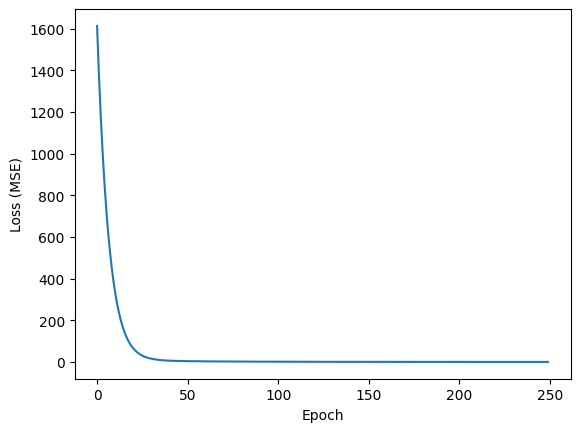

In [38]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()

In [39]:
yhat = f(x)
yhat # initial predicted values kinda suck 

tensor([ 0.0000,  1.0665,  2.1331,  ..., 94.2682, 95.3347, 96.4012],
       grad_fn=<SqueezeBackward0>)

You can see bellow the original plane we were trying to fit in blue and approximation in red. 

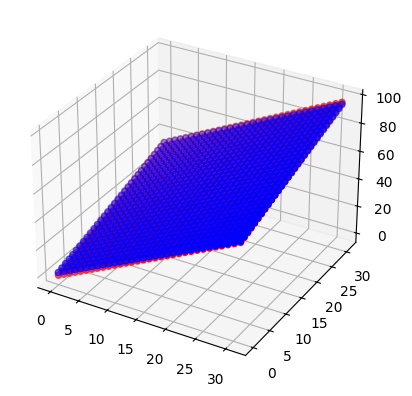

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0],x[:,1],y, c='b')
ax.scatter(x[:,0],x[:,1],y_hat.detach(), c='r')
plt.show()